In [33]:
# copyright ############################### #
# This file is part of the Xtrack Package.  #
# Copyright (c) CERN, 2021.                 #
# ######################################### #
import ducktrack as dtk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from tqdm import tqdm

import xtrack as xt
import xobjects as xo
import xpart as xp
from scipy import constants 


In [46]:
"""Test the electron cooler by comparing the cooling rate and cooling force with Betacool for Leir.
"""

import numpy as np
import xtrack as xt
import xpart as xp

# Define constants
beta_rel = 0.09423258405
gamma = 1.004469679
current = 0.6  # Amperes
cooler_length = 2.5  # m
radius_e_beam = 25 * 1e-3  # m
temp_perp = 100e-3  # eV
temp_long = 1e-3  # eV
magnetic_field = 0.075  # T for LEIR
mass0 = 193729.0248722061 * 1e6  # eV/c^2
clight = 299792458.0  # m/s
p0c = mass0 * beta_rel * gamma  # eV/c
q0 = 54  # Charge
circumference = 78.54370266  # m
s_per_turn = circumference / (clight * beta_rel)
beta_x = 5  # m
beta_y = 5  # m
emittance = 14 * 1e-6  # Initial geometric emittance (m·rad)

# Reference particle
particle_ref = xp.Particles(p0c=p0c, mass0=mass0, q0=q0)

# Electron cooler
cooler = xt.ElectronCooler(
    current=current,
    length=cooler_length,
    radius_e_beam=radius_e_beam,
    temp_perp=temp_perp,
    temp_long=temp_long,
    magnetic_field=magnetic_field
)

# Load Betacool force data
data_betacool = np.load('force_betacool.npz')
v_diff_betacool = data_betacool['v_diff']
force_betacool = data_betacool['force']

# Generate particles for testing
num_particles = int(1e4)
dtk_particle = xp.Particles(
    mass0=mass0,
    p0c=p0c,
    q0=q0,
    x=np.random.normal(0, 1e-20, num_particles),
    px=np.random.normal(0, 4 * np.sqrt(emittance / beta_x), num_particles),
    y=np.random.normal(0, 1e-20, num_particles),
    py=np.random.normal(0, 1e-20, num_particles),
    delta=np.zeros(num_particles),
    zeta=np.zeros(num_particles)
)

# Set up line and track particles
line = xt.Line(elements=[cooler])
line.particle_ref = particle_ref
line.build_tracker()

# Start internal logging for the electron cooler
record = line.start_internal_logging_for_elements_of_type(
    xt.ElectronCooler, capacity=10000
)

line.track(dtk_particle)

# Extract recorded forces
force = record.Fx

# Compute velocity difference
px_tot = p0c * dtk_particle.px
beta_diff = px_tot / (mass0 * gamma)
v_diff = beta_diff * clight

# Sort forces and velocities by velocity difference
sorted_indices = np.argsort(v_diff)
v_diff = v_diff[sorted_indices]
force = force[sorted_indices]

# Match Betacool and Xsuite indices
v_diff_betacool = v_diff_betacool[~np.isnan(v_diff_betacool)]
matching_indices = [np.abs(v_diff - vb).argmin() for vb in v_diff_betacool]

force_xsuite = np.array([force[i] for i in matching_indices])
force_betacool_matched = force_betacool[:len(v_diff_betacool)]

xo.assert_allclose(force_xsuite, force_betacool_matched, rtol=0, atol=10)


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [48]:
xo.assert_allclose(force_xsuite, force_betacool_matched, rtol=0, atol=5)

In [35]:

# """Test the electron cooler by comparing the cooling rate and cooling force with Betacool for Leir.
# """


# beta_rel = 0.09423258405
# gamma = 1.004469679
# current = 0.6  # amperes
# cooler_length = 2.5  # m cooler length
# radius_e_beam = 25 * 1e-3
# temp_perp = 100e-3 # <E> [eV] = kb*T
# temp_long =  1e-3 # <E> [eV]
# magnetic_field = 0.075  # T for LEIR
# mass0 = 193729.0248722061 * 1e6  # eV/c^2
# clight = 299792458.0
# p0c = mass0 * beta_rel * gamma  # eV/c
# q0 = 54
# circumference = 78.54370266  # m
# s_per_turn = circumference / (clight * beta_rel)
# beta_x = 5
# beta_y = 5

# particle_ref = xp.Particles(p0c=p0c, mass0=mass0, q0=q0)

# emittance = 14 * 1e-6  # initial emittance


# cooler = xt.ElectronCooler(
#     current=current, length=cooler_length, radius_e_beam=radius_e_beam,
#     temp_perp=temp_perp, temp_long=temp_long, magnetic_field=magnetic_field)

# data_betacool = np.load('force_betacool.npz')
# v_diff_betacool = data_betacool['v_diff']
# force_betacool = data_betacool['force']
# num_particles = int(1e4)

# dtk_particle = xp.Particles(
#     mass0=mass0,
#     p0c=p0c,
#     x=np.random.normal(0, 1e-20, num_particles),
#     px=np.random.normal(0, 4*np.sqrt(emittance/beta_x), num_particles),
#     y=np.random.normal(0, 1e-20, num_particles),
#     py=np.random.normal(0, 1e-20, num_particles),
#     delta=np.random.normal(0, 0, num_particles),
#     zeta=np.random.normal(0, 0, num_particles),
#     q0=q0)


# line = xt.Line(elements=[cooler])                                    
# line.particle_ref = particle_ref
# line.build_tracker()

# record = line.start_internal_logging_for_elements_of_type(
#                                                     xt.ElectronCooler, capacity=10000)

# line.track(dtk_particle)

# force=record.Fx

# px_tot = p0c*dtk_particle.px
# beta_diff = px_tot/(mass0*gamma)
# v_diff = beta_diff*clight

# sorted_indices = np.argsort(v_diff)
# v_diff = v_diff[sorted_indices]
# force = force[sorted_indices]
# for i in range(len(v_diff_betacool) - 1, -1, -1):
#     if not np.isnan(v_diff_betacool[i]):
#         last_non_nan_index = i
#         break

# v_diff_betacool = v_diff_betacool[:last_non_nan_index]

# matching_indices = []
# for time_value in v_diff_betacool:
#     index = np.abs(v_diff - time_value).argmin()
#     matching_indices.append(index)

# force_xsuite = [force[i] for i in matching_indices]

# force_betacool = force_betacool[:last_non_nan_index]

# force_diff = force_xsuite - force_betacool
# mse_force_transverse = np.mean(force_diff**2)



In [36]:
mse_force_transverse

np.float64(0.06626123991967973)

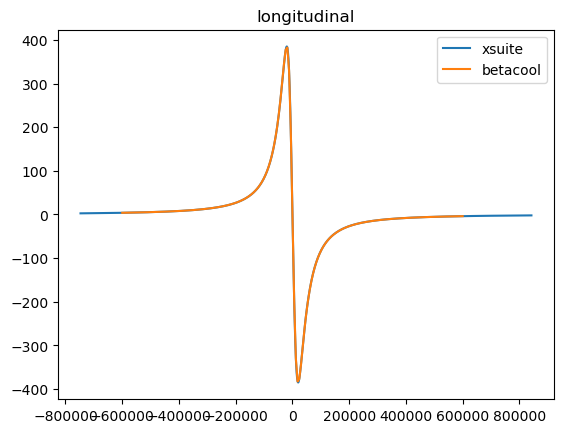

In [37]:
plt.figure()
plt.title('longitudinal')
plt.plot(v_diff,force,label='xsuite')
plt.plot(v_diff_betacool,force_betacool,label='betacool')
# plt.xlim([0,200000])
plt.legend()
plt.show()

In [38]:
force

array([ 2.60308285,  2.91072371,  2.96921014, ..., -3.2748736 ,
       -2.89721231, -2.09609862])

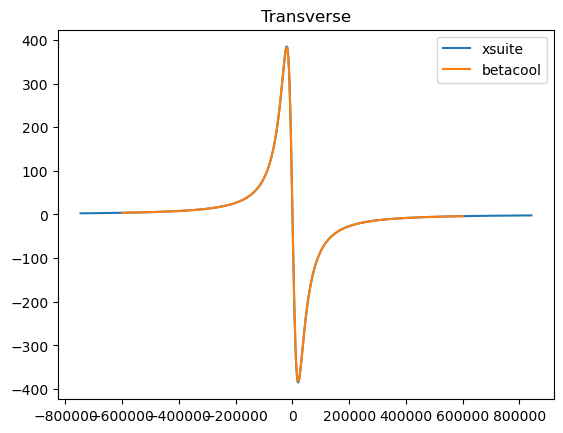

In [39]:
plt.figure()
plt.title('Transverse')
plt.plot(v_diff,force,label='xsuite')
plt.plot(v_diff_betacool,force_betacool,label='betacool')
plt.legend()
plt.show()



In [40]:
num_particles=int(1e5)
gamma0=gamma
beta0=beta_rel
sigma_dp = 1e-2 # from Schotttky
delta=np.linspace(-sigma_dp,sigma_dp,num_particles)
dtk_particle = dtk.TestParticles(
    mass0=mass0,
    gamma0=gamma0,
    p0c=p0c,
    q0=q0,
    x=np.random.normal(0,0 ,num_particles),
    px=np.random.normal(0,0 ,num_particles),
    y=np.random.normal(0, 0 ,num_particles),
    py=np.random.normal(0, 0 ,num_particles),
    delta= delta,
    zeta=np.random.normal(0, 0 ,num_particles),
    )


dtk_cooler = dtk.elements.ElectronCooler(current=current,
                    length=cooler_length,
                    radius_e_beam=radius_e_beam,
                    temp_perp=temp_perp, temp_long=temp_long,
                    magnetic_field=magnetic_field, magnetic_field_ratio=0,
                    space_charge_factor=0,
                    offset_energy=0)

Fx,Fy,force = dtk_cooler.force(dtk_particle)

c=constants.c

##################################################################################################

v_electron_nominal = beta0*c
momentum_diff = delta*p0c
#assume gamma is constant for small momentum deviation
v_diff_longitindal = c*momentum_diff/(mass0*gamma0)

# ##################################################################################################
# px_tot = p0c*dtk_particle.px
# beta_diff = px_tot/(mass0*gamma)
# v_diff = beta_diff*c
# Sort v_diff and force in ascending order
sort_indices = np.argsort(v_diff_longitindal)
v_diff_longitindal = v_diff_longitindal[sort_indices]
force_longitudinal = force[sort_indices]



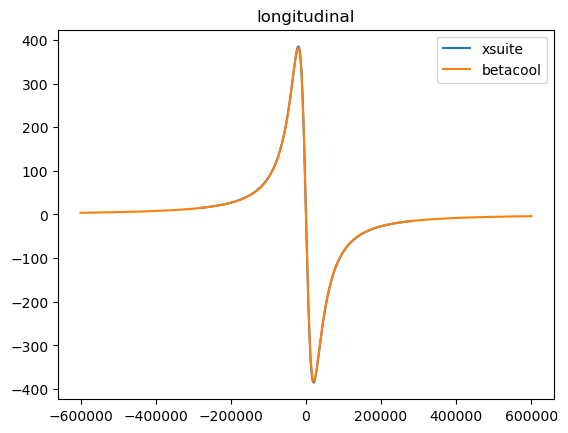

In [41]:
plt.figure()
plt.title('longitudinal')
plt.plot(v_diff_longitindal,force_longitudinal,label='xsuite')
plt.plot(v_diff_betacool,force_betacool,label='betacool')
# plt.xlim([0,200000])
plt.legend()
plt.show()

In [42]:
matching_indices = []
for time_value in v_diff_betacool:
    index = np.abs(v_diff_longitindal - time_value).argmin()
    matching_indices.append(index)

force_longitudinal = [force_longitudinal[i] for i in matching_indices]


force_diff_longitudinal = force_longitudinal - force_betacool
mse_force_longitudinal = np.mean(force_diff_longitudinal**2)

In [43]:
mse_force_longitudinal

np.float64(34.421530973592525)